This is the template for DS3000 Final data analysis project. Once you finish, please remove all my instructions. You do not need to exactly follow the structure in the template but please make sure you have all the components. Write your report in paragraphs. Only use bullet points when list something (eg: functions) 

# Investigating Palworld Through Data Analysis
#### Team 11
- Ansh Aggarwal
- Sohum Balsara
- Bear Smith

In [11]:
# imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import tree

## Introduction

In this project we study Palworld, a survival and monster-taming video game in which players collect characters called Pals to battle each other and help build their bases. Each Pal has a different set of skills and qualifications, a combination of such features as their element type, their HP in battle, and their "work suitability" for various tasks like farming or electricity production. We want to learn about how those factors combine and influence each other, and what relationships that may not be stated outwardly can be found between them. This may help players better understand their game and be more successful at it, or at least increase their knowledge of the logic behind Palworld.

Our primary research questions are:
- How are a Pal's work suitability scores correlated to its other statistics, such as its element type or battle skills?
- What relationship does Pal rarity have with their other statistics?

## Data 

### Data Source
- All data was taken from the [palworld.gg]("https://palworld.gg") database.
- We scraped each Pal's name, ID number, rarity, element(s), work suitability type(s) and level(s), HP, and defense scores.
- To make the data frame more easily filtered, the Pals' elements were listed using multiple boolean columns, each representing one element.
- For that same reason, their work suitabilities were also listed by column, but instead of True or False, each value was the Pal's level in that suitability or Nan if they did not have it. That way, dropna can be used to filter the data frame by element type.
- Finally, the Pals' HP and defense stats were converted to numbers in the data frame, so that mathematical operations can be done on those columns.

### Webscraping and cleaning functions overview
- `scrape_pal_ids()`
    - Creates a data frame with all the Pals' names as its index and one column of data containing their IDs.
- `scrape_pal_rarity()`
    - Adds a column containing the rarity of each Pal to the given data frame.
- `scrape_pal_elements()`
    - Adds the element or elements of each Pal to the given data frame using one-hot columns.
- `scrape_pal_work()`
    - Adds the work suitability or suitabilities of each Pal to the given data frame, along with its level.
- `scrape_pal_hp()`
    - Adds a column containing the HP of each Pal to the given data frame.
- `scrape_pal_defense()`
    - Adds a column containing the defense score of each Pal to the given data frame.

### Data overview
You can see a couple rows of our data below. We store the Pals' rarity, their element or elements, their work suitabilities with levels, and their HP and defense scores, all of which are measured and modeled against each other in our analysis. Our target feature is always one of them. The data set is not perfect: For the purposes of analysis, it could stand to be larger, as 225 Pals is relatively few when they are split up among various permutations of 9 elements and 9 work suitabilities. However, that's out of our control. We could have scraped more of the Pals' battle statistics, since some interesting analysis could probably be done on that, but none of our present ideas required them.

In [ ]:
pal_frame = pd.read_excel("pal_frame_for_project.xlsx")
# Reset the index back to the Pal names after reading in the spreadsheet file.
pal_frame.set_index("Unnamed: 0", inplace = True)
pal_frame.rename_axis(None, axis = 0, inplace = True)
pal_frame.head()

Index(['ID', 'Rarity', 'Earth', 'Fire', 'Dragon', 'Dark', 'Electricity',
       'Water', 'Ice', 'Leaf', 'Normal', 'Handiwork', 'Mining', 'Transporting',
       'Number of work suitabilities', 'Deforesting', 'Kindling', 'Gathering',
       'Generating Electricity', 'Watering', 'Cooling', 'Farming',
       'Medicine Production', 'Planting', 'HP', 'Defense'],
      dtype='object')

## Webscraping and cleaning

In [ ]:
# list all the functions you have for webscraping and cleaning. Make sure write full 
# docstrings for each function

def scrape_pal_ids(url = "https://palworld.gg/pals"):
    """
    Scrape Pal IDs from the given URL.

    Args:
        url (str): The URL of the Palworld database page, assumed to be the current link unless otherwise specified.

    Returns:
        DataFrame: A dataFrame of Pal names and IDs.
    """
    response = requests.get(url).text
    soup = BeautifulSoup(response)

    # Find all Pal ID elements
    pal_dict = {}
    for pal in soup.find_all("div", class_ = "pal"):

        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Get the ID and name of the Pal and add them to the dictionary.
        pal_id_element = pal.find('span', class_='index').text.strip()
        pal_dict[pal.find("div", class_ = "name").next_element.strip()] = pal_id_element

    # Convert the dictionary to a DataFrame before returning it.
    return pd.DataFrame().from_dict(pal_dict, orient = "index", columns = ["ID"])

In [ ]:
def scrape_pal_rarity(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the rarity of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with the rarity of each Pal added under a new column.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find all Pals, then find each of their rarities.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:

        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # The "name" class is used twice in each Pal entry, first for their name, then for their rarity.
        name_class = pal.find_all("div", class_ = "name")
        # (Using next_element here rather than .text to avoid also getting the text from the nested children.)
        # Add the rarity of the Pal to the DataFrame under its name.
        pal_df.loc[name_class[0].next_element.strip(), "Rarity"] = name_class[1].next_element

    return pal_df


In [ ]:
def scrape_pal_elements(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the element or elements of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a dummy variable added for each element,
        True meaning that a Pal does belong to them and False for not.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the Pal's name.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Initialize all the element column values for this Pal to False, as none have been found yet.
        pal_df.loc[pal_name, ["Earth", "Fire", "Dragon", "Dark", "Electricity", "Water", "Ice", "Leaf", "Normal"]] = False

        # Scrape the elements of the Pal.
        pal_elems_tags = pal_soup.find("div", class_ = "elements").find_all("div", class_ = "name")
        for tag in pal_elems_tags:
            # For each found element, change the Pal's value in the corresponding column to True.
            pal_df.loc[pal_name, tag.text] = True
        
    return pal_df


In [ ]:
def scrape_pal_work(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the work suitabilities of each Pal listed in the database, including the level of each work type.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with 13 new columns added: 12 representing the work suitabilities
        of Pals, each filled with NaN or the Pal's skill level for that task, and one column counting the number of suitabilities
        the Pal has in total.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the suitabilities of the Pal, and for each one that is found add its level to the column with the suitability's name.
        pal_work_tags = pal_soup.find("div", class_ = "works").find_all("div", class_ = "active item")
        for tag in pal_work_tags:
            pal_df.loc[pal_name, tag.find("div", class_ = "name").text] = tag.find("span", class_ = "value").text
        # Add the pal's total number of suitabilities as a new column.
        pal_df.loc[pal_name, "Number of work suitabilities"] = len(pal_work_tags)
        
    return pal_df


In [ ]:
def scrape_pal_hp(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the HP of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a new column representing the Pals' HPs.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the HP of the pal (the first entry in the stats section) and add it to the HP column.
        pal_hp = int(pal_soup.find("div", class_ = "stats").find_all("div", class_ = "value")[0].text)
        pal_df.loc[pal_name, "HP"] = pal_hp
        
    return pal_df


In [ ]:
def scrape_pal_defense(pal_df, url = "https://palworld.gg/pals"):
    """
    Scrape the defense score of each Pal listed in the database.

    Args:
        url (str): The URL of the database page, assumed to be the current link unless otherwise specified.
        pal_df (DataFrame): The DataFrame of Pal data to update.

    Returns:
        pal_df (DataFrame): The DataFrame given, with a new column representing the Pals' defense scores.
    """
    soup = BeautifulSoup(requests.get(url).text)

    # Find each Pal entry.
    pal_tag = soup.find_all("div", class_ = "pal")
    for pal in pal_tag:
        # Remove empty Pal entries.
        if pal.attrs["style"] == "display:none;":
            continue

        # Load the individual entry page for the Pal.
        pal_page = requests.get("https://palworld.gg" + pal.a.attrs["href"]).text
        pal_soup = BeautifulSoup(pal_page)

        # Scrape the name of the Pal.
        pal_name = pal_soup.find("h1", class_ = "name").text.strip()

        # Scrape the defense of the pal (the second entry in the stats section) and add it to the defense column.
        pal_hp = int(pal_soup.find("div", class_ = "stats").find_all("div", class_ = "value")[1].text)
        pal_df.loc[pal_name, "Defense"] = pal_hp
        
    return pal_df


In [ ]:
pal_df = scrape_pal_defense(scrape_pal_hp(scrape_pal_work(scrape_pal_elements(scrape_pal_rarity(scrape_pal_ids())))))
pal_df

## Visualizations
# TODO all these
### Visualization functions overview
List all the functions you have written for visualization. For each one, write one sentence to describe it. 
- `make_hist()`
    - Generate a histogram with given data and feature
 
### Visualization results
- Present 3-4 data visualizations.
- For each visualization, you need to include title, xlabel, ylabel, legend (if necessary)
- For each visualization, explain why you make this data visualization (how it related to your research question) and explain what you have learned from this visualization

In [32]:
# TODO docstrings for 2nd

def build_work_features(df, work_list):
    """ Creates a data frame based on the given frame of Pal data with three new features added: 
    Each Pal's highest work suitability level, a list of all its suitabilities, and its total number of suitabilities.

    Args:
        df (DataFrame): The data frame to draw Pal data from and base the return frame off of.
        work_list (list(str)): The titles of the columns containing Pal work data in the given frame.

    Returns:
        out (DataFrame): A copy of the given data frame with the three new columns added to it.
    """
    
    # Initialize the return data frame as a copy of the given one.
    out = df.copy()

    # Grab the subset of the data frame representing the work columns.
    work_cols = df[work_list]

    # For every row of the data frame:
    for idx in range(len(work_cols)):
        # Declare a series variable for the work stats of the Pal at this row and drop all NaN values, 
        # which would be the work suitabilities it doesn't have.
        pal = work_cols.iloc[idx, :]
        pal = pal.dropna()

        # Get the Pal's highest work suitability level by sorting the series and place it into the data frame.
        out.loc[pal.name, "Highest Work Suitability Level"] = pal.sort_values(ascending = False).iloc[0]

        # Get a string of the Pal's work types by joining all of its non-NaN work labels and place it into the data frame.
        out.loc[pal.name, "Work Types"] = ", ".join(pal.index)

        # Get the number of work types the Pal has as the length of the index and place it into the data frame.
        out.loc[pal.name, "Work Skill Count"] = len(pal.index)

    return out


def group_work_by_element(df, work_list):
    """ Makes a data frame representing each the Pals' average scores in each work suitability by element.
    (Note that many Pals have multiple elements and thus have to be counted for each of them.)

    Args:
        df (DataFrame): The data frame to draw Pal data from and base the return frame off of.
        work_list (list(str)): The titles of the columns containing Pal work data in the given frame.
    
    Returns:
        work_elem_stats (DataFrame): A data frame with elements for its index and work suitabilities for its columns,
        populated in each cell with the average score of all the Pals in that element at that work skill.
    """

    # Declare a list of the elements.
    element_list = ["Earth", "Fire", "Dragon", "Dark", "Electricity", "Water", "Ice", "Leaf", "Normal"]

    # Initialize an empty data frame to hold the return values.
    work_elem_stats = pd.DataFrame(index = element_list, columns = work_list, dtype = float)
    
    # For every element:
    for elem in element_list:
        # Get all the pals who have that element == True.
        current_pals = df.loc[df[elem], :]

        # For all the work suitabilities:
        for work in work_list:
            # Take the mean of all the current Pals' stats in that job, filling NaNs with 0, and place it into the data frame.
            work_elem_stats.loc[elem, work] = current_pals[work].fillna(value = 0, inplace = False).mean()

    return work_elem_stats


# Declare the names of work-type columns
work_list = ['Handiwork', 'Mining',
       'Transporting', 'Deforesting',
       'Kindling', 'Gathering', 'Generating Electricity', 'Watering',
       'Cooling', 'Farming', 'Medicine Production', 'Planting']

# Define fixed colors for each element
element_colors = {
    "Earth": "#8B4513",
    "Fire": "#FF4500",
    "Dragon": "#800080",
    "Dark": "#2F4F4F",
    "Electricity": "#FFD700",
    "Water": "#1E90FF",
    "Ice": "#00CED1",
    "Leaf": "#228B22", 
    "Normal": "#A9A9A9"
}

# Prepare the data frame for visualizations
pal_frame_vis = build_work_features(pal_frame, work_list)

#### visualization 1

In [33]:
# 1. Scatter plot
fig1 = px.scatter(
    pal_frame_vis.sort_values(by = "Highest Work Suitability Level", ascending = True),
    x="Highest Work Suitability Level",
    y="HP",
    color="Element Type",
    hover_data={"ID":True, "Rarity":True, "Work Types":True},
    title="Work Suitability vs HP by Element Type"
)
fig1.show()

#### visualization 2

In [34]:
# 2. Grouped Bar Chart
work_elem_stats = group_work_by_element(pal_frame_vis, work_list)

fig2 = px.bar(
    work_elem_stats,
    barmode="group",
    title="Average Work Suitability Level by Element Type & Work Type",
    labels = {"value" : "Average skill level", "index" : "Element Type", "variable" : "Work skill" }
)
fig2.show()

#### visualization 3

In [ ]:
# 3. Heatmap
heat_df = pal_frame_vis.groupby(["Rarity","Work Skill Count"]).size().reset_index(name="Count")
print(heat_df)
fig3 = px.density_heatmap(
    heat_df,
    x="Work Skill Count", y="Rarity", z="Count", color_continuous_scale="Viridis",
    title="Rarity vs. Number of Work Suitabilities (Frequency)"
)
fig3.
fig3.show()

       Rarity  Work Skill Count  Count
0      Common               1.0     36
1      Common               2.0     19
2      Common               3.0     22
3      Common               4.0     19
4      Common               5.0      4
5      Common               7.0      1
6        Epic               1.0     12
7        Epic               2.0     14
8        Epic               3.0      9
9        Epic               4.0      4
10       Epic               5.0      5
11  Legendary               1.0      4
12  Legendary               2.0      2
13  Legendary               3.0      2
14       Rare               1.0     17
15       Rare               2.0     21
16       Rare               3.0     14
17       Rare               4.0     11
18       Rare               5.0      8
19       Rare               6.0      1


In [ ]:
# 4. Boxplots
fig4 = px.box(pal_frame_vis, x="Rarity", y="HP", color="Element Type",
              title="HP Distribution by Rarity")
fig4.show()

fig5 = px.box(pal_frame_vis, x="Rarity", y="Defense", color="Element Type",
              title="Defense Distribution by Rarity")
fig5.show()

## Models

### Modeling functions overview
List all the functions you have written for modeling. For each one, write one sentence to describe it. 
- `fit_linear()`
    - fit a linear model to the data and output the r2, slope and intercept

### Model results

- Present 2-3 models for the analysis.
- Explain any pre-processing steps you have done (eg: scaling, polynomial, dummy features)
- For each model, explain why you think this model is suitable and what metrics you want to use to evaluate the model
    - If it is a classification model, you need to present the confusion matrix, calculate the accuracy, sensitivity and specificity with cross-validation
    - If it is a regression model, you need to present the r2 and MSE with cross-validation
    - If it is a linear regression model/multiple linear regression model, you need to interpret the meaning of the coefficient with the full data
    - If it is a decision tree model, you need to plot the tree with the full data
    - If it is a random forest model, you need to present the feature importance plot with the full data
    - If it is a PCA, you need to explain how to select the number of components and interpret the key features in the first two components
    - If it is a clustering, you need explain how to select the number of clustering and summarize the clustering. 

In [ ]:
# list all the functions you have for modeling. Make sure write full 
# docstrings for each function
def fit_linear(df, y_feat, x_feat):
    """
    Fit a linear model to the data and output the r2, slope and intercept.
   Args:
        df (DataFrame): The DataFrame of Pal data to use.
        y_feat (str): The name of the feature to use as the dependent variable.
        x_feat (str): The name of the feature to use as the independent variable.
    Returns:
        r2 (float): The r-squared value of the fitted model.
        slope (float): The slope of the fitted model.
        intercept (float): The intercept of the fitted model.
    """
    
    # Drop rows with NaN values in the specified columns.
    clean_df = df[[y_feat, x_feat]].dropna()
    X = clean_df[[x_feat]].to_numpy().reshape(-1, 1)
    y = clean_df[y_feat].to_numpy()
    # Split the data into training and testing sets.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Fit the linear regression model.
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Make predictions on the test set.
    y_pred = model.predict(X_test)
    # Calculate the r-squared value, slope, and intercept.
    r2 = r2_score(y_test, y_pred)
    slope = model.coef_[0]
    intercept = model.intercept_
    return r2, slope, intercept

#### Model 1

In [8]:
# Write the code to run functions to fit each model in separate code chunks.
r2, slope, intercept = fit_linear(pal_frame_vis, "HP", "Highest Work Suitability Level")
print(f"Model 1: R2 = {r2}, Slope = {slope}, Intercept = {intercept}")

Model 1: R2 = 0.3991006793555303, Slope = 12.481549523296692, Intercept = 66.27680466250673


In [9]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results.

# Replot the scatter plot with the fitted line
fig1 = px.scatter(
    pal_frame_vis.sort_values(by = "Highest Work Suitability Level", ascending = True),
    x="Highest Work Suitability Level",
    y="HP",
    color="Element Type",
    hover_data={"ID":True, "Rarity":True, "Work Types":True},
    title="Work Suitability vs HP by Element Type"
)
fig1.add_scatter(
    x=pal_frame_vis["Highest Work Suitability Level"],
    y=intercept + slope * pal_frame_vis["Highest Work Suitability Level"],
    mode="lines",
    name="Fitted Line",
    line=dict(color="red", width=2)
)
fig1.show()
#Tthe fitted line shows a positive correlation between work suitability level and HP, indicating that Pals with higher work suitability levels tend to have higher HP. The slope of the line suggests that for each unit increase in work suitability level, the HP increases by approximately `slope` units. The R2 value indicates how well the model explains the variance in HP based on work suitability level.

#### Model 2

[Text(0.5, 0.875, 'HP <= 87.5\ngini = 0.657\nsamples = 225\nvalue = [101, 44, 8, 72]\nclass = Common'),
 Text(0.25, 0.625, 'Defense <= 100.0\ngini = 0.198\nsamples = 81\nvalue = [72, 0, 0, 9]\nclass = Common'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'HP <= 72.5\ngini = 0.145\nsamples = 76\nvalue = [70, 0, 0, 6]\nclass = Common'),
 Text(0.0625, 0.125, 'gini = 0.051\nsamples = 38\nvalue = [37, 0, 0, 1]\nclass = Common'),
 Text(0.1875, 0.125, 'gini = 0.229\nsamples = 38\nvalue = [33, 0, 0, 5]\nclass = Common'),
 Text(0.375, 0.375, 'HP <= 82.5\ngini = 0.48\nsamples = 5\nvalue = [2, 0, 0, 3]\nclass = Rare'),
 Text(0.3125, 0.125, 'gini = 0.375\nsamples = 4\nvalue = [1, 0, 0, 3]\nclass = Rare'),
 Text(0.4375, 0.125, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0, 0]\nclass = Common'),
 Text(0.75, 0.625, 'HP <= 112.5\ngini = 0.672\nsamples = 144\nvalue = [29, 44, 8, 63]\nclass = Rare'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'Defense <= 107.5\ngini = 0.625\nsamples = 111\nva

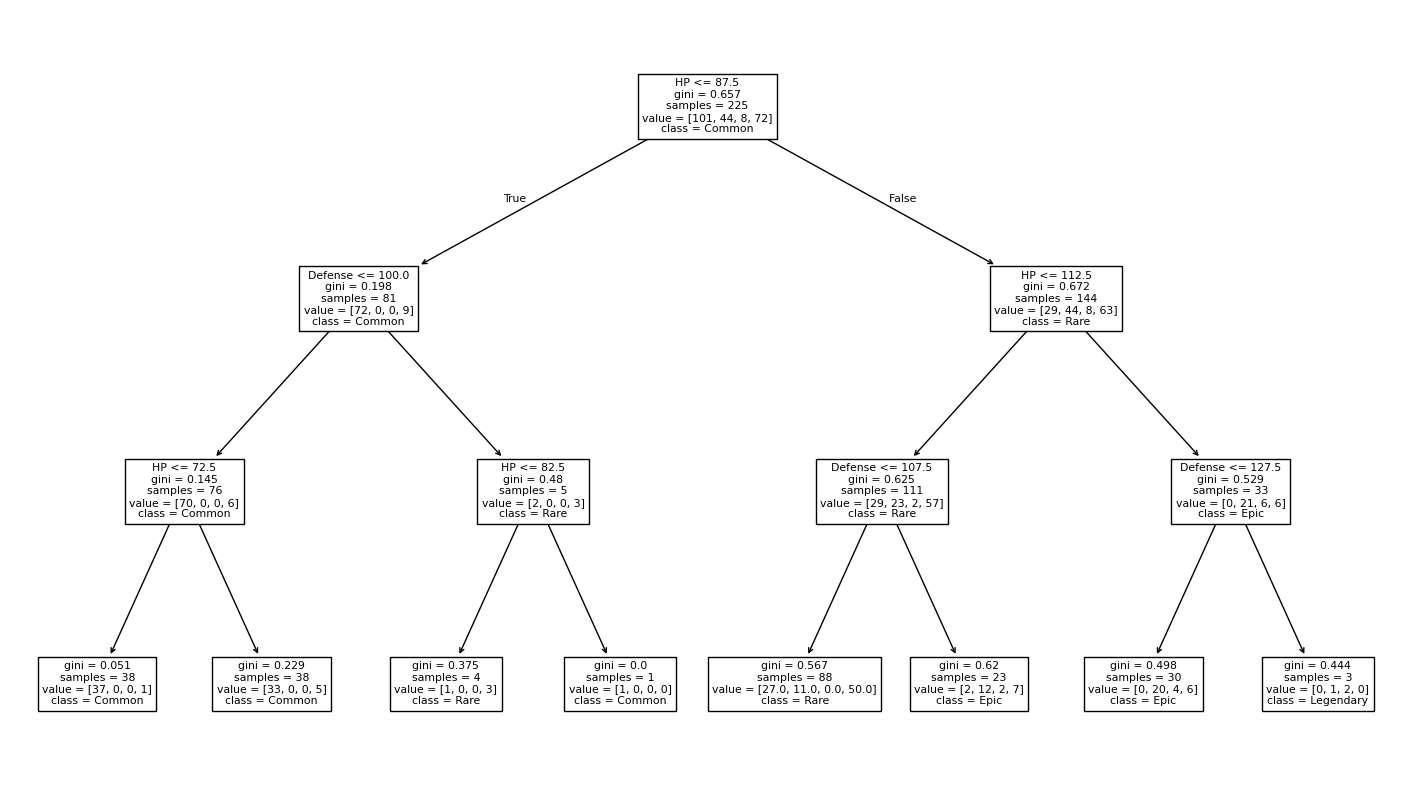

In [12]:
x = pal_frame[["HP", "Defense"]]
y = pal_frame["Rarity"]

pal_dec_tree = tree.DecisionTreeClassifier(max_depth = 3)
pal_dec_tree.fit(x, y)
plt.figure()
plt.gcf().set_size_inches(18, 10)
tree.plot_tree(pal_dec_tree, feature_names = ["HP", "Defense"], class_names = pal_dec_tree.classes_)

#### Model 3

In [ ]:
# Write the code to run functions to fit each model in separate code chunks. 
# Interpret the model results. 

## Discussion

- One or two paragraphs to summarize your findings in the modeling sections and do the models answer your research question?
- Any other potential thing you can do with the analysis (eg: include more features, get more data, try some other models etc.)
- List the contribution for each group member.

### Contributions
- Sohum came up with the majority of our research questions and visualization ideas.
- Bear wrote the web scraping functions.
- Ansh wrote the data visualizations.
- 